# Gas CART

## Import and load

In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.cluster_generator import ClusterGenerator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils.evaluator import Evaluator
import prince
import numpy as np
from sklearn.svm import SVC, SVR
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-21 20:38:29.724284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734809909.759406  214854 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734809909.769284  214854 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 20:38:29.848815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical

### Load GAS type cars

In [2]:
data = Loader.load_by_fueltype("Gas")
label_encoder = LabelEncoder()

/home/liingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on t

In [3]:
data["price_categ"].value_counts()

price_categ
Middle low range     509
Budget               480
Low end              250
Middle range          31
Middle high range     16
Very low end           3
High end               1
Luxury                 0
Premiun                0
Name: count, dtype: int64

In [4]:
data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares
    'Luxury': 'Alto',
    'Premiun': 'Alto',
    'High end': 'Alto',
    'Middle high range': 'Alto',
})

data = data[data['price_categ'] != 'Very low end'] # Eliminar la clase 'Very low end'
data['price_categ'] = data['price_categ'].str.strip()

# Revisa la nueva distribución
data['price_categ'].value_counts()

/tmp/ipykernel_214854/787252135.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares


price_categ
Middle low range    509
Budget              480
Low end             250
Middle range         31
Alto                 17
Name: count, dtype: int64

In [5]:
# Ajustar y transformar la columna price_categ
data['price_categ'] = data["price_categ"].apply(Loader.encode_price_categ).to_numpy()
data['price_categ'].value_counts()

price_categ
3    509
2    480
1    250
4     31
8     17
Name: count, dtype: int64

#### We can see the data is hightly unbalance and needs treatment before reating the tree model 

Aproach 1

**SMOTE**

This method addresses data imbalance by generating synthetic samples for the minority class.





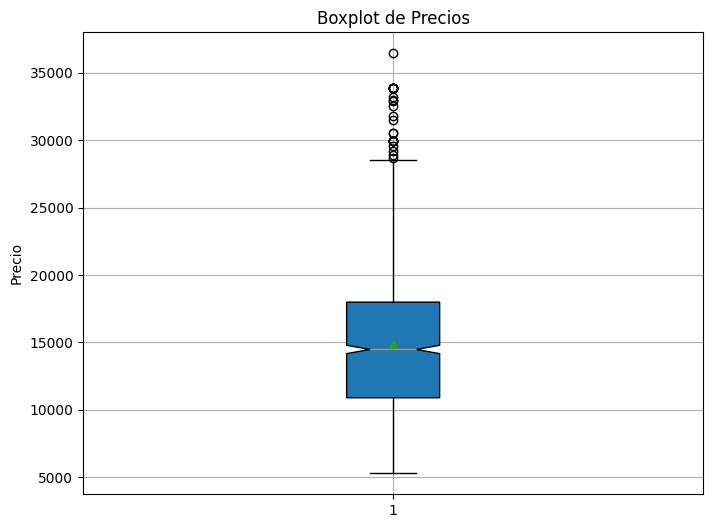

In [6]:
precios_gas = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_gas, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [7]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

28625.0


,price,brand
idx,,
48483,36441,DFSK
24917,33900,EVO
43137,33900,EVO
43076,33900,EVO
40872,33900,EVO
85825,33900,EVO
91054,33900,EVO
37736,33900,EVO
34644,33899,PIAGGIO


### Gas , Numerical variables selection

In [8]:
def fill_gas_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")

    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_gas_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id"], inplace=True)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_gas_numerical_columns(numerical_columns)

def get_gas_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = Data_processor.remove_redundand_columns(ret)
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [9]:
numerical_columns = get_gas_numerical_columns(data)
categorical_columns = get_gas_categorical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.9674673980367783%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 15.456430834096583%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.050674953115151%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 4.822246491513321%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 3.4546319076731002%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 9.7883866267976%
Number of missing values in 'version' before filling with 'unknown': 0
Number of missing values in 'jato_classification' before filling with 'unknown': 6
Number of missing values in 'brakes' before filling with 'unknown': 6
Number of missing values in 'front_suspension' before filling with 'unknown': 0
Number of missing values in 'rear_suspension' before filling with 'unknown': 0


In [10]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                    1.000000
km                      -0.666253
year                     0.630371
cubicCapacity            0.134931
doors                    0.196730
seatingCapacity          0.262632
trunkCapacityInLiters    0.200050
maxSpeed                 0.029122
acceleration            -0.190765
power_cv                 0.438754
power_kw                 0.444135
max_torque_nm            0.351313
speakers                 0.187856
dimensions.width         0.315454
dimensions.height        0.161946
dimensions.length        0.305562
Numero_Testigos          0.010558
displacement_liters      0.132262
displacement_cc          0.171891
number_of_cylinders     -0.147125
compression_ratio       -0.511080
Llantas_Diametro_cm      0.512251
price_categ              0.890447
Name: price, dtype: float64


In [11]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

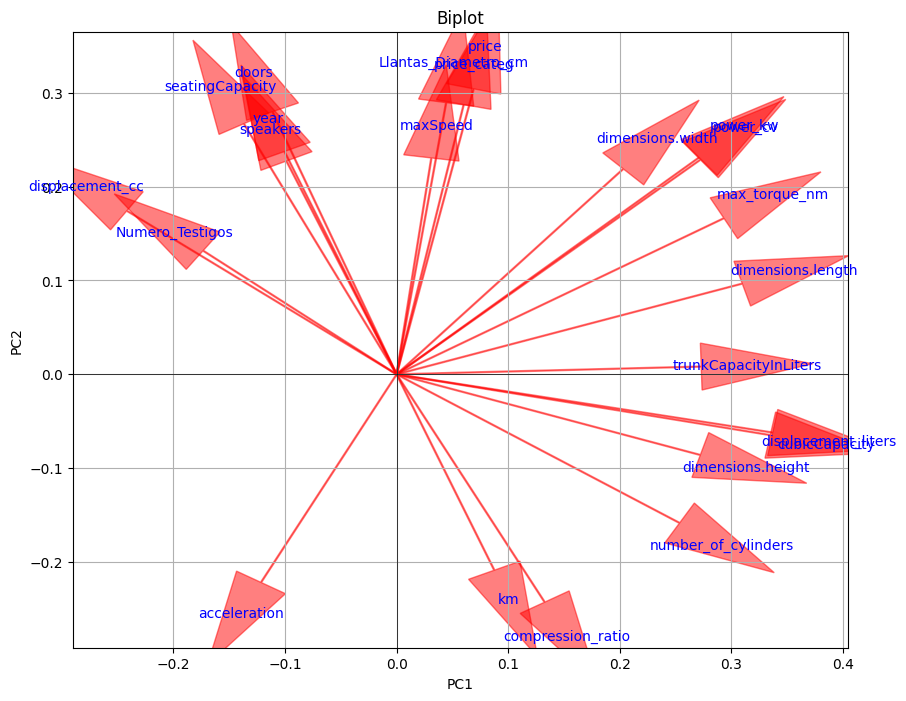

In [12]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## CART regression with only numerical values

- Using only numerical values we can use the SMOTE technique to generate synthetic value data and rebalance our unbalance dataset.

### SMOTE

In [13]:
X = numerical_columns.drop(columns=["price_categ","price"]) # + price_categ
y = numerical_columns["price_categ"]

In [14]:
# Train-Test Split Before Applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Training the CART Model (Decision Tree) on Resampled Data

In [16]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [17]:
y_pred = clf.predict(X_test)

# Cell 7: Evaluate the Model
# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.74      0.77        58
           2       0.78      0.78      0.78        94
           3       0.84      0.92      0.88        91
           4       0.86      0.43      0.57        14
           8       0.33      1.00      0.50         1

    accuracy                           0.80       258
   macro avg       0.72      0.77      0.70       258
weighted avg       0.81      0.80      0.80       258

Confusion Matrix:
 [[43 15  0  0  0]
 [11 73 10  0  0]
 [ 0  6 84  1  0]
 [ 0  0  6  6  2]
 [ 0  0  0  0  1]]


After analyzing the results obtained with and without the application of SMOTE, it was observed that models trained without SMOTE demonstrated superior performance in terms of accuracy and stability. Although SMOTE is an effective technique for balancing imbalanced datasets by synthesizing new samples, in this specific case, the models without SMOTE outperformed those with it. 

**Therefore future models will be trained without SMOTE from this point forward.**

# Clasification


In [18]:
def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"] - result["Prediction"]
    Evaluator.eval_ordinal_classification(diff=abs(result["diff"]))

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier = classifier
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        return Evaluator.eval_classification(y_pred = y_pred,  y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    return Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False)



In [19]:
gas_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how='inner')
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

target = gas_cars[["price", "price_categ"]]
gas_cars.drop(columns=["price"], inplace=True)

numerical_column_names.remove("price")


encoders_and_scalers = {}
for column in numerical_column_names:
    scaler = StandardScaler()
    gas_cars[[column]] = scaler.fit_transform(gas_cars[[column]])
    encoders_and_scalers[column] = scaler 

gas_cars_encoded = pd.get_dummies(gas_cars, columns=categorical_column_names)

### CART

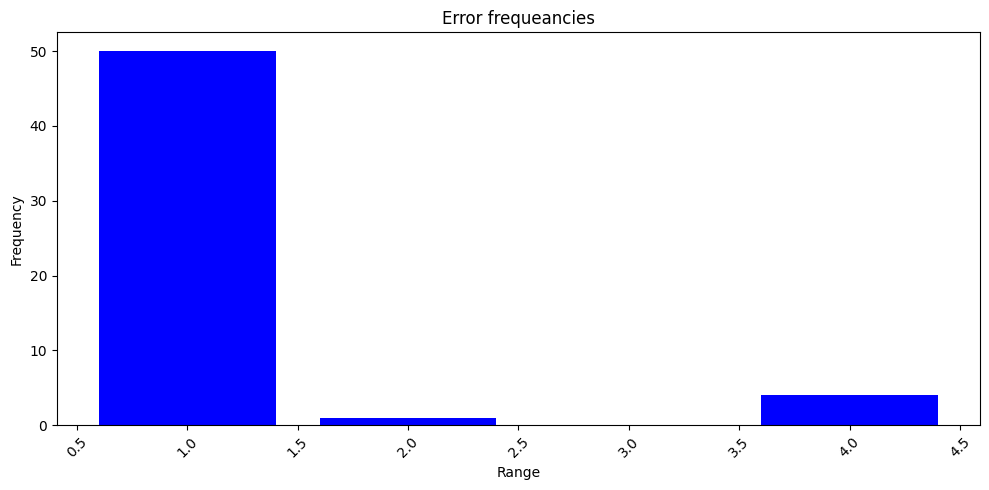

{1: 50, 2: 1, 4: 4}
Error mean: 1.2363636363636363
Error rate: 21.31782945736434 %
Overall mean: 0.26356589147286824
Accuracy: 0.7868217054263565 
 Precision: 0.7963486485656501 
 Recall: 0.7868217054263565 
 F1 Score: 0.7865221653006835
Confusion Matrix:
 [[43 15  0  0  0]
 [15 70  9  0  0]
 [ 0  7 83  1  0]
 [ 0  1  3  6  4]
 [ 0  0  0  0  1]]


In [20]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

### Random forest
Random forest can get a better result at a higher computational time cost

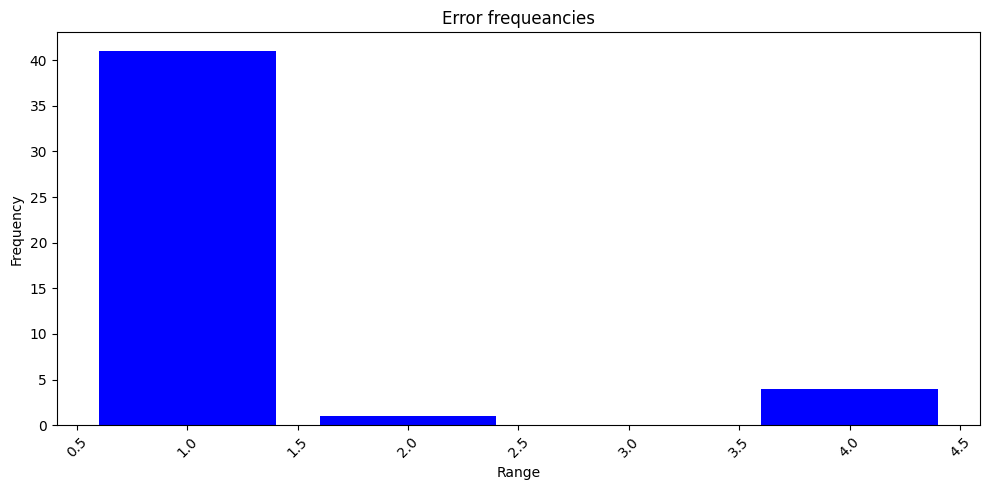

{1: 41, 2: 1, 4: 4}
Error mean: 1.2826086956521738
Error rate: 17.829457364341085 %
Overall mean: 0.22868217054263565
Accuracy: 0.8217054263565892 
 Precision: 0.8343891402714931 
 Recall: 0.8217054263565892 
 F1 Score: 0.821667352710664
Confusion Matrix:
 [[42 16  0  0  0]
 [ 9 80  5  0  0]
 [ 0  7 83  1  0]
 [ 0  1  3  6  4]
 [ 0  0  0  0  1]]


In [21]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

### SVM
Much higher computational cost, more distributed error, but in overall worse result

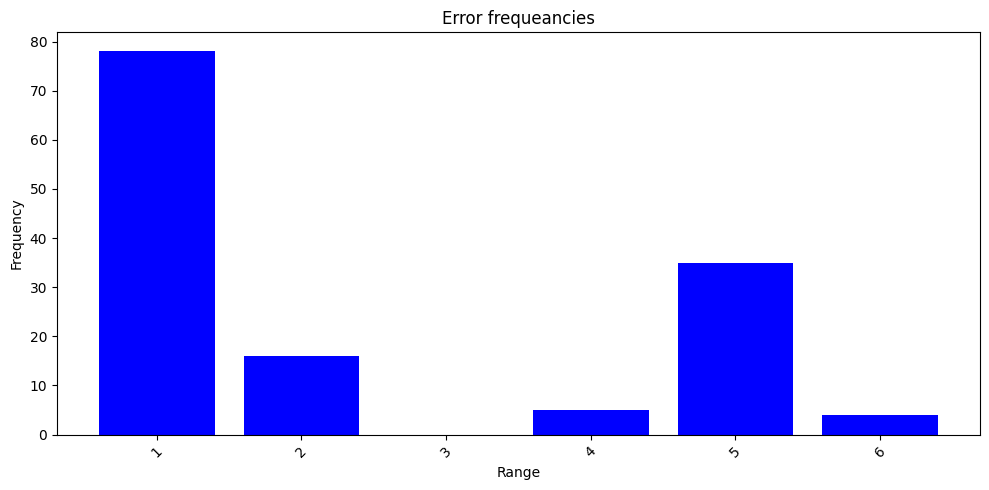

{1: 78, 2: 16, 4: 5, 5: 35, 6: 4}
Error mean: 2.3840579710144927
Error rate: 53.48837209302325 %
Overall mean: 1.2751937984496124
Accuracy: 0.46511627906976744 
 Precision: 0.5540080012693231 
 Recall: 0.46511627906976744 
 F1 Score: 0.47521715533018155
Confusion Matrix:
 [[43 12  3  0  0]
 [32 50  8  0  4]
 [ 5 25 26  0 35]
 [ 0  8  1  0  5]
 [ 0  0  0  0  1]]


/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
classify(X_train_resampled, X_test, y_train_resampled, y_test, SVC(random_state=42), classifier_name="SVC")

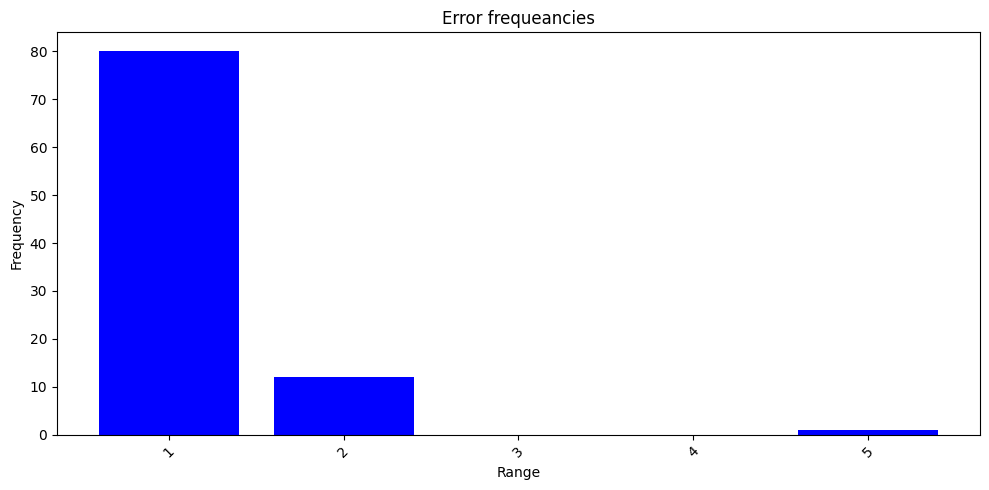

{1: 80, 2: 12, 5: 1}
Error mean: 1.1720430107526882
Error rate: 36.04651162790697 %
Overall mean: 0.42248062015503873
Accuracy: 0.6395348837209303 
 Precision: 0.6417469867882253 
 Recall: 0.6395348837209303 
 F1 Score: 0.6186482228263861
Confusion Matrix:
 [[27 27  4  0  0]
 [ 5 76 13  0  0]
 [ 0 29 62  0  0]
 [ 0  8  6  0  0]
 [ 0  0  1  0  0]]


/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

### Naive bayes

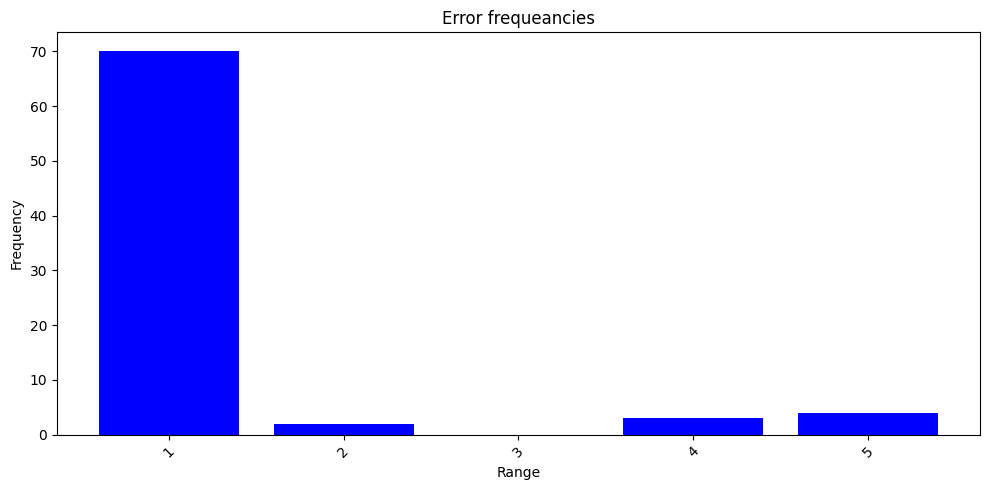

{1: 70, 2: 2, 4: 3, 5: 4}
Error mean: 1.3417721518987342
Error rate: 30.620155038759687 %
Overall mean: 0.4108527131782946
Accuracy: 0.6937984496124031 
 Precision: 0.7252094505195179 
 Recall: 0.6937984496124031 
 F1 Score: 0.7019359225902136
Confusion Matrix:
 [[46 12  0  0  0]
 [27 57 10  0  0]
 [ 2 13 65  7  4]
 [ 0  0  1 10  3]
 [ 0  0  0  0  1]]


In [24]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes")

### ANN

In [25]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(data[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    gas_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734809919.202223  214854 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7304 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:06:00.0, compute capability: 8.6
W0000 00:00:1734809919.444019  215023 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/liingfeng/Desktop/cuml/lib/pyt

Epoch 1/100


I0000 00:00:1734809920.496835  215006 service.cc:148] XLA service 0x7eff980088f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734809920.496852  215006 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-21 20:38:40.519394: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1734809920.607058  215006 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1734809920.616106  215006 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was c

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_214854/1625366539.py", line 25, in <module>

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_1644]

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [ ]:
Evaluator.eval_classification(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

## Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(gas_cars_encoded, precios_gas, test_size=0.3, random_state=42)

In [ ]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor = regressor
    regressor.fit(X_train, y_train)
    # Predicting the test set results
    y_pred = regressor.predict(X_test)

    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, bins=5, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name=regressor_name)
    Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)

### Cart

In [ ]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

### Random Forest

In [ ]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

### SVM Regression

In [ ]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

### Multivariable regression

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

In [ ]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

In [ ]:
result

 ### ANN

In [ ]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)


In [ ]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

In [ ]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [ ]:
y_pred = model.predict(X_test).flatten()

In [ ]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

In [ ]:
Evaluator.save("gas")

# Clustering

In [32]:
ground_truth = gas_cars_encoded["price_categ"]

In [33]:
cluster_generator = ClusterGenerator(gas_cars_encoded.drop(columns=["price_categ"]), use_cuml=True)

In [34]:
cluster_generator.generate(n_trials=5, ground_truth=ground_truth)

[I 2024-12-21 20:42:17,653] A new study created in memory with name: no-name-0bf02ed1-bccc-460e-9797-71685fc74934


Optimizing method: kmeans


[I 2024-12-21 20:42:19,181] Trial 0 finished with value: 0.19637512720964115 and parameters: {'n_clusters': 7, 'init': 'k-means++', 'n_init': 21, 'max_iter': 439}. Best is trial 0 with value: 0.19637512720964115.
[I 2024-12-21 20:42:21,080] Trial 1 finished with value: 0.2025326366077342 and parameters: {'n_clusters': 10, 'init': 'k-means++', 'n_init': 27, 'max_iter': 167}. Best is trial 1 with value: 0.2025326366077342.
[I 2024-12-21 20:42:22,513] Trial 2 finished with value: 0.24918657673773814 and parameters: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 21, 'max_iter': 199}. Best is trial 2 with value: 0.24918657673773814.
[I 2024-12-21 20:42:23,752] Trial 3 finished with value: 0.211986095885711 and parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 22, 'max_iter': 196}. Best is trial 2 with value: 0.24918657673773814.
[I 2024-12-21 20:42:25,104] Trial 4 finished with value: 0.2295431152026121 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 23, 'max_i

Optimizing method: agglomerative


[I 2024-12-21 20:42:28,902] Trial 0 finished with value: 0.1706518540802327 and parameters: {'n_clusters': 2, 'linkage': 'ward'}. Best is trial 0 with value: 0.1706518540802327.
[I 2024-12-21 20:42:34,515] Trial 1 finished with value: 0.16924841409491778 and parameters: {'n_clusters': 8, 'linkage': 'single'}. Best is trial 0 with value: 0.1706518540802327.
[I 2024-12-21 20:42:36,705] Trial 2 finished with value: 0.15418922619816672 and parameters: {'n_clusters': 5, 'linkage': 'complete'}. Best is trial 0 with value: 0.1706518540802327.
[I 2024-12-21 20:42:42,334] Trial 3 finished with value: 0.012031144587665315 and parameters: {'n_clusters': 15, 'linkage': 'single'}. Best is trial 0 with value: 0.1706518540802327.
[I 2024-12-21 20:42:44,502] Trial 4 finished with value: 0.14578467695915473 and parameters: {'n_clusters': 9, 'linkage': 'complete'}. Best is trial 0 with value: 0.1706518540802327.
/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervise

Optimizing method: dbscan


[I 2024-12-21 20:42:47,932] Trial 0 finished with value: -0.006100631938313354 and parameters: {'eps': 1.3477784433482314, 'min_samples': 17, 'algorithm': 'brute'}. Best is trial 0 with value: -0.006100631938313354.
[I 2024-12-21 20:42:48,722] Trial 1 finished with value: -1.0 and parameters: {'eps': 0.2436969018333823, 'min_samples': 17, 'algorithm': 'auto'}. Best is trial 0 with value: -0.006100631938313354.
[I 2024-12-21 20:42:49,478] Trial 2 finished with value: -1.0 and parameters: {'eps': 0.19080507593088267, 'min_samples': 19, 'algorithm': 'auto'}. Best is trial 0 with value: -0.006100631938313354.
[I 2024-12-21 20:42:50,350] Trial 3 finished with value: -0.14998798072225114 and parameters: {'eps': 0.35691342377590035, 'min_samples': 9, 'algorithm': 'brute'}. Best is trial 0 with value: -0.006100631938313354.
[I 2024-12-21 20:42:51,241] Trial 4 finished with value: -0.25188094891192514 and parameters: {'eps': 0.5811960924209961, 'min_samples': 9, 'algorithm': 'auto'}. Best is tr

Optimizing method: birch


[I 2024-12-21 20:42:54,297] Trial 0 finished with value: 0.22176355702598133 and parameters: {'threshold': 0.4609454175736115, 'n_clusters': 10, 'branching_factor': 34}. Best is trial 0 with value: 0.22176355702598133.
[I 2024-12-21 20:42:56,377] Trial 1 finished with value: 0.2580959053376934 and parameters: {'threshold': 0.49865367501170454, 'n_clusters': 15, 'branching_factor': 70}. Best is trial 1 with value: 0.2580959053376934.
[I 2024-12-21 20:42:58,463] Trial 2 finished with value: 0.23604430031944632 and parameters: {'threshold': 0.3604748229043072, 'n_clusters': 11, 'branching_factor': 67}. Best is trial 1 with value: 0.2580959053376934.
[I 2024-12-21 20:42:59,895] Trial 3 finished with value: 0.22583309639096724 and parameters: {'threshold': 0.7430421583973796, 'n_clusters': 11, 'branching_factor': 40}. Best is trial 1 with value: 0.2580959053376934.
[I 2024-12-21 20:43:01,544] Trial 4 finished with value: 0.24004819072095362 and parameters: {'threshold': 0.8010056998215899, 

Optimizing method: optics


/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/sklearn/cluster/_optics.py:664: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
[I 2024-12-21 20:43:04,264] Trial 0 finished with value: -1.0 and parameters: {'min_samples': 13, 'max_eps': 0.143807876057025, 'metric': 'minkowski', 'cluster_method': 'xi'}. Best is trial 0 with value: -1.0.
/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/sklearn/cluster/_optics.py:664: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
[I 2024-12-21 20:43:04,515] Trial 1 finished with value: -1.0 and parameters: {'min_samples': 20, 'max_eps': 0.3837645930391857, 'metric': 'euclidean', 'cluster_method': 'dbscan'}. Best is trial 0 with value: -1.0.
[I 2024-12-21 20:43:07,994] Trial 2 finished with value: -0.16406826354671394 and parameters: {'min_samples': 16, 'max_eps': 1.6704197022551928, 

Optimizing method: gmm


[I 2024-12-21 20:43:15,990] Trial 0 finished with value: 0.1838206651272888 and parameters: {'n_components': 6, 'covariance_type': 'spherical', 'tol': 0.0002219760770172421, 'reg_covar': 3.934263558626235e-06, 'max_iter': 140}. Best is trial 0 with value: 0.1838206651272888.
[I 2024-12-21 20:44:22,724] Trial 1 finished with value: 0.20831046958847863 and parameters: {'n_components': 12, 'covariance_type': 'tied', 'tol': 0.0021721153059831503, 'reg_covar': 0.00821120137455715, 'max_iter': 161}. Best is trial 1 with value: 0.20831046958847863.
[I 2024-12-21 20:44:23,282] Trial 2 finished with value: 0.2310430797773276 and parameters: {'n_components': 3, 'covariance_type': 'diag', 'tol': 0.00026564816659645137, 'reg_covar': 0.0003233454141996387, 'max_iter': 116}. Best is trial 2 with value: 0.2310430797773276.
[I 2024-12-21 20:49:44,740] Trial 3 finished with value: 0.20369182989599408 and parameters: {'n_components': 11, 'covariance_type': 'full', 'tol': 0.00013574997152770266, 'reg_cov

{'internalEvaluation': {'Algorithm': ['kmeans',
   'agglomerative',
   'dbscan',
   'birch',
   'optics',
   'gmm'],
  'silhouette_score': [0.24918657673773814,
   0.1706518540802327,
   -0.006100631938313354,
   0.2580959053376934,
   -0.16406826354671394,
   0.2310430797773276],
  'calinski_harabasz_score': [287.67385620093694,
   248.67818257412216,
   20.933458542509094,
   178.73450726102743,
   17.55127893562196,
   270.808917360441],
  'davies_bouldin_score': [1.4326663359577634,
   2.0906440571672547,
   1.0215348751442062,
   1.4422800479585525,
   1.1832647750624736,
   1.7204365855348935]},
 'externalEvaluation': {'Algorithm': ['kmeans',
   'agglomerative',
   'dbscan',
   'birch',
   'optics',
   'gmm'],
  'adjusted_rand_score': [0.14470883648092137,
   0.07970033227327794,
   0.021484288143870003,
   0.07956819588338576,
   0.02324962366045841,
   0.08016569356969573],
  'normalized_mutual_info_score': [0.15539671184431264,
   0.10987181607460414,
   0.0567021171832858,
  

In [35]:
cluster_generator.internalEvaluation

{'Algorithm': ['kmeans', 'agglomerative', 'dbscan', 'birch', 'optics', 'gmm'],
 'silhouette_score': [0.24918657673773814,
  0.1706518540802327,
  -0.006100631938313354,
  0.2580959053376934,
  -0.16406826354671394,
  0.2310430797773276],
 'calinski_harabasz_score': [287.67385620093694,
  248.67818257412216,
  20.933458542509094,
  178.73450726102743,
  17.55127893562196,
  270.808917360441],
 'davies_bouldin_score': [1.4326663359577634,
  2.0906440571672547,
  1.0215348751442062,
  1.4422800479585525,
  1.1832647750624736,
  1.7204365855348935]}

In [36]:
cluster_generator.save("gas")